# POS Tagging - An Overview

The process of classifying words into their __parts of speech__ and labeling them accordingly is known as **part-of-speech tagging**, or simply **POS-tagging**.

The NLTK library has a number of corpora which contains word and its POS tag. The following table provide information about each tag:

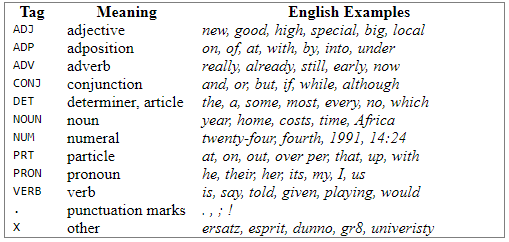

# Notebook layout
1. Preprocess data
2. Vanilla RNN
3. Word Embeddings
4. LSTM
5. GRU
6. Bidirectional LSTM
7. Model Evaluation

In [6]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


### why we need POS tagging , for Example

* Sentence 1- This is a green leaf **Here greens means Adjective**
* Sentence 2- I like greens in my food  **Here greens means Noun**
* Sentence 3- The greens that you see there is golf course  **Here greens means Noun**



# 1. Preprocess data
#### Load the Data

In [7]:
import nltk
nltk.download('universal_tagset')
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

In [8]:
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [9]:
# let's look at the data
tagged_sentences[11]

[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB'),
 ('at', 'ADP'),
 ('risk', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('James', 'NOUN'),
 ('A.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('of', 'ADP'),
 ('Boston', 'NOUN'),
 ("'s", 'PRT'),
 ('Dana-Farber', 'NOUN'),
 ('Cancer', 'NOUN'),
 ('Institute', 'NOUN'),
 ('.', '.')]

## Divide data in words (X) and tags (Y)

Since this is a **many-to-many** problem, each data point will be a different sentence of the corpora.

Each data point will have multiple words in the **input sequence**. This is what we will refer to as **X**.

Each word will have its correpsonding tag in the **output sequence**. This what we will refer to as **Y**.

Sample dataset:

|                    X                        |                 Y                |
|---------------------------------------------|----------------------------------|
|   Mr. Vinken is chairman of Elsevier        |   NOUN NOUN VERB NOUN ADP NOUN   |
|     We have no useful information           |      PRON VERB DET ADJ NOUN      |

In [10]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:  # In here entity will fetch on word by word and we append that into X
    # for eg word such as  [('We', 'PRON'),('have', 'VERB'),('no', 'DET'),('useful', 'ADJ')]  here in entity in 1 itr we get  ('We', 'PRON')  so we 
    #fetch "we" in X and "PRON" in Y and so on
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [11]:
X[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

**COnverting the words and tage in lower case**

In [12]:
num_words=[inner_loop.lower() for outer_loop in X for inner_loop in outer_loop]

In [13]:
num_words[:10]

['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the']

In [14]:
# length of numbr of words
len(num_words)

1520972

In [15]:
# length of Vocubulary
num_words=len(set([word.lower() for sentence in X for word in sentence]))

## Similarly for Number of tags


In [16]:
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [17]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


#### lets have a peek of the data

In [18]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ',X[0],"\n")
print('sample X: ',Y[0],"\n")

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample X:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [19]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


## Vectorise X and Y

#### Encode X and Y to integer values

We'll use the Tokenizer() function from Keras library to encode text sequence to integer sequence

**Encoding X**

In [20]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [21]:
word_index=word_tokenizer.word_index
type(word_index)

dict

#### Tokenizer assign values to each word lets have alook on the first 10 words and the value assigned to it

In [22]:
{k:word_index[k] for k in list(word_index)[:10]}

{',': 2,
 '.': 3,
 'a': 7,
 'and': 5,
 'for': 10,
 'in': 8,
 'of': 4,
 'that': 9,
 'the': 1,
 'to': 6}

**Encoding Y**

In [23]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [24]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0])
print('Y: ', Y[0])
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0])
print('Y: ', Y_encoded[0])

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']

** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3]
Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3]


**Make sure that each sequence of input and output is same length**

In [25]:
nl=0
for i in range(len(X)):
  if len(X[i])==len(Y[i]):
    nl=0
  else:
    nl=1
if nl==1:
  print("Diff Length")
else:
  print("Same length")


Same length


# Altrenate way using comprehension

In [26]:
different_length=[1 if len(inputs)!=len(output) else 0 for inputs,output in zip(X_encoded,Y_encoded)]

In [27]:
["Difflength" if sum(different_length) else "Same Length"]

['Same Length']

## Pad sequences

The next step after encoding the data is to define the sequence lengths. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a hyperparameter.

#### lets check for the max length in the encode sequence

In [28]:
lengths=[len(i) for i in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


<function matplotlib.pyplot.show>

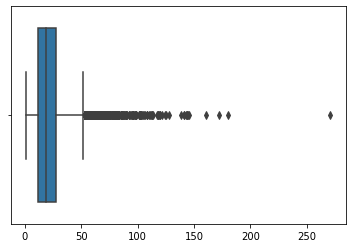

In [29]:
sns.boxplot(lengths)
plt.show

### here we from the boxplot there are few outliers i.e few senteces are quite long so we simply get rid of thoso sentences
### Or simply we can truncate these sentences to the length so that they are no more Outliers

In [30]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 110  # sequences greater than 110 in length will be truncated
X_padded=pad_sequences(X_encoded,maxlen=MAX_SEQ_LENGTH,padding="pre",truncating="post")
Y_padded=pad_sequences(Y_encoded,maxlen=MAX_SEQ_LENGTH,padding="pre",truncating="post")

In [31]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0  6423 24231     2  7652
   102   170     2    47  1898     1   269    17     7 13230   619  1711
  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  3 11
  1  6  3  2  2  5  1  4  5  6  1

## RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [32]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Word embeddings
Currently, each word and each tag is encoded as an integer. 

We'll use a more sophisticated technique to represent the input words (X) using what's known as **word embeddings**.

However, to represent each tag in Y, we'll simply use **one-hot encoding** scheme since there are only 13 tags in the dataset and the LSTM will have no problems in learning its own representation of these tags.

To use word embeddings, you can go for either of the following models:
1. word2vec model: https://code.google.com/archive/p/word2vec/
2. GloVe model : https://nlp.stanford.edu/projects/glove/

We're using the word2vec model for no particular reason. Both of these are very efficient in representing words. You can try both and see which one works better.

Dimensions of a word embedding is: (VOCABULARY_SIZE, EMBEDDING_DIMENSION)

## Downloading the pre-trained Word2vec google model(word2vec-google-news-300)

* downloading pre traine word2vec embeding weights, also we made tweak in the weights which are pre-trained

In [33]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [34]:
path = '/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [35]:
# word2vec effectiveness
#word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

# Output-
[('Queen', 0.4929388165473938),

 ('Tupou_V.', 0.45174291729927063),

 ('Oprah_BFF_Gayle', 0.4422132670879364),

 ('Jackson', 0.440250426530838),

 ('NECN_Alison', 0.43312832713127136),

 ('Whitfield', 0.42834725975990295),

 ('Ida_Vandross', 0.42084527015686035),

 ('prosecutor_Dan_Satterberg', 0.42075902223587036),

 ('martin_Luther_King', 0.42059648036956787),
 
 ('Coretta_King', 0.42027339339256287)]

# It means- King-Men+women=Queen, i.e why queen prob is very high in the result we get

# Assign word vectors from word2vec model

In [36]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1 # becuse 0 was included in padding and 0 is not included any conversion thats way means
# if , = 2, 0 is 0 not assigned anything

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

In [37]:
{i: word2id[i] for i in list(word2id)[:10]}

{',': 2,
 '.': 3,
 'a': 7,
 'and': 5,
 'for': 10,
 'in': 8,
 'of': 4,
 'that': 9,
 'the': 1,
 'to': 6}

In [38]:

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

### Explaination of this code
* i.e where for eg- 'a': 7, then from word2vec corresponding prob value of 7 is assigned and so on

In [39]:
dt={5:0,
    9:1,
    11:2}
na=np.zeros((3,2))
na

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [40]:
for i ,j in dt.items():
  na[j, :] = i
na

array([[ 5.,  5.],
       [ 9.,  9.],
       [11., 11.]])

In [41]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [42]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

In [43]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']].shape

(300,)

## here JOY is assigned to all 300 dimensions for each feature represenation like(Gender,Royal,Age, food etc.)

# Use one-hot encoding for output sequences (Y)**

In [44]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [45]:
# print Y of the first output sequqnce
print(Y.shape)

(72202, 110, 13)


# Split data in training, validation and tesing sets

**Note here splitting is of sentences not of words**

In [46]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

**Validation split**

In [47]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [48]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 110)
Shape of output sequences: (52165, 110, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 110)
Shape of output sequences: (9206, 110, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 110)
Shape of output sequences: (10831, 110, 13)


Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

Shape of X:
(#samples, #timesteps, #features)

Shape of Y:
(#samples, #timesteps, #features)


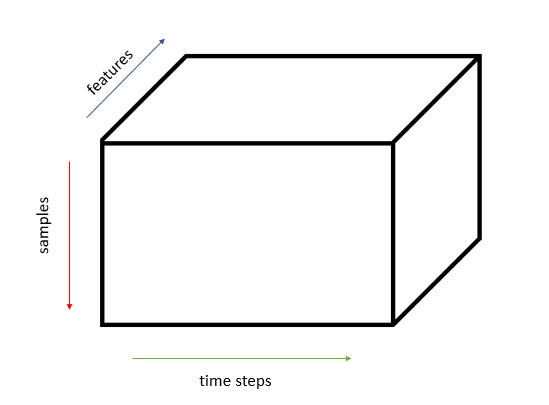

Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

# 2. Vanilla RNN

### Uninitialised fixed embeddings
First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.

In [49]:
# total number of tags
NUM_CLASSES = Y.shape[2]
NUM_CLASSES

13

In [50]:
print("VOCABULARY_SIZE",VOCABULARY_SIZE)
print("EMBEDDING_SIZE",EMBEDDING_SIZE)
print('MAX_SEQ_LENGTH',MAX_SEQ_LENGTH)

VOCABULARY_SIZE 59449
EMBEDDING_SIZE 300
MAX_SEQ_LENGTH 110


In [51]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

**TimeDistributed**
* It means we are not going to wait till the end of the sentence, the output of RNN is picked up and made predictions at evert Time Steps
* We have sequence of words coming as embedding and as in when we see more and more words in a sequence, we go try predicting the POS tags for each of word.
i.e Everytime we had a word we already have context of the previous part of the sentence, Using that context and current word we try to predict what the POS tag for this new word.
So we not wait for end of sequence and try to come up with prediction after every word.... this is what Time Distributed does

**Embedding**
* Think of embedding as Matrix multiplication Eg-
If we were given a vector of length 10 and we want to embed this a shorter vector of length 5, The transformation we apply is in form of matrix of order (5*10) so--

(5*10) matrix multiplication (10*1) result is (5*1)

**trainable=False**
* Means the weights here are frozed they are static

## Compile model

In [52]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [53]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 110, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 110, 13)          845       
 ibuted)                                                         
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


**Since we have done trainable     =  False**

* Most of parameters are non-trainable over here

## Fit model

In [54]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 52s 120ms/step - loss: 0.4854 - acc: 0.8631 - val_loss: 0.3181 - val_acc: 0.9037
Epoch 2/10
408/408 [==============================] - 50s 122ms/step - loss: 0.2639 - acc: 0.9193 - val_loss: 0.2210 - val_acc: 0.9322
Epoch 3/10
408/408 [==============================] - 49s 119ms/step - loss: 0.1995 - acc: 0.9382 - val_loss: 0.1798 - val_acc: 0.9433
Epoch 4/10
408/408 [==============================] - 48s 117ms/step - loss: 0.1688 - acc: 0.9462 - val_loss: 0.1568 - val_acc: 0.9495
Epoch 5/10
408/408 [==============================] - 48s 116ms/step - loss: 0.1499 - acc: 0.9515 - val_loss: 0.1415 - val_acc: 0.9541
Epoch 6/10
408/408 [==============================] - 47s 115ms/step - loss: 0.1372 - acc: 0.9551 - val_loss: 0.1311 - val_acc: 0.9568
Epoch 7/10
408/408 [==============================] - 48s 117ms/step - loss: 0.1283 - acc: 0.9577 - val_loss: 0.1239 - val_acc: 0.9588
Epoch 8/10
408/408 [==============================] - 4

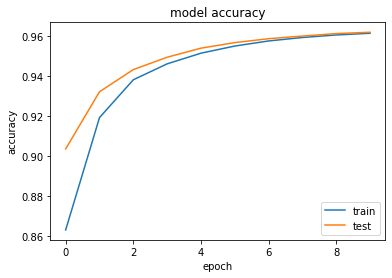

In [55]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Uninitialised trainable embeddings
* by doing Trainable=True i.e weigth are allowed to train

In [56]:
# create architecture

rnn_model = Sequential()
# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))


# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))


# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [57]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [58]:
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 110, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 110, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 110, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


**Since we have done trainable     =  True**

* Most of parameters are Trainable over here

## Fit model

In [59]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 65s 156ms/step - loss: 0.2121 - acc: 0.9520 - val_loss: 0.0421 - val_acc: 0.9880
Epoch 2/10
408/408 [==============================] - 64s 156ms/step - loss: 0.0296 - acc: 0.9907 - val_loss: 0.0279 - val_acc: 0.9906
Epoch 3/10
408/408 [==============================] - 64s 156ms/step - loss: 0.0199 - acc: 0.9932 - val_loss: 0.0253 - val_acc: 0.9911
Epoch 4/10
408/408 [==============================] - 63s 155ms/step - loss: 0.0163 - acc: 0.9942 - val_loss: 0.0245 - val_acc: 0.9913
Epoch 5/10
408/408 [==============================] - 63s 155ms/step - loss: 0.0142 - acc: 0.9950 - val_loss: 0.0244 - val_acc: 0.9915
Epoch 6/10
408/408 [==============================] - 63s 153ms/step - loss: 0.0124 - acc: 0.9956 - val_loss: 0.0250 - val_acc: 0.9913
Epoch 7/10
408/408 [==============================] - 62s 153ms/step - loss: 0.0108 - acc: 0.9963 - val_loss: 0.0257 - val_acc: 0.9913
Epoch 8/10
408/408 [==============================] - 6

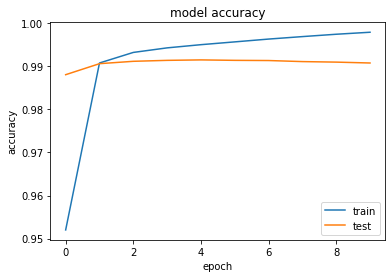

In [62]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## here both accuracy and val accuracy are high by using the trainable weights

# Using pre-trained embedding weights

By taking the pre trained weights of Word2Vec which we have done before in this excercise. also we are allowe=ing them to be tweaked by doung trainabel =True

In [66]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [67]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 110, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 110, 64)           23360     
                                                                 
 time_distributed_3 (TimeDis  (None, 110, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [68]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 69s 166ms/step - loss: 0.1753 - acc: 0.9648 - val_loss: 0.0329 - val_acc: 0.9897
Epoch 2/10
408/408 [==============================] - 67s 163ms/step - loss: 0.0250 - acc: 0.9917 - val_loss: 0.0252 - val_acc: 0.9913
Epoch 3/10
408/408 [==============================] - 66s 163ms/step - loss: 0.0184 - acc: 0.9935 - val_loss: 0.0235 - val_acc: 0.9916
Epoch 4/10
408/408 [==============================] - 66s 162ms/step - loss: 0.0156 - acc: 0.9944 - val_loss: 0.0230 - val_acc: 0.9918
Epoch 5/10
408/408 [==============================] - 66s 161ms/step - loss: 0.0137 - acc: 0.9951 - val_loss: 0.0230 - val_acc: 0.9918
Epoch 6/10
408/408 [==============================] - 66s 161ms/step - loss: 0.0121 - acc: 0.9957 - val_loss: 0.0234 - val_acc: 0.9919
Epoch 7/10
408/408 [==============================] - 66s 161ms/step - loss: 0.0107 - acc: 0.9963 - val_loss: 0.0242 - val_acc: 0.9917
Epoch 8/10
408/408 [==============================] - 6

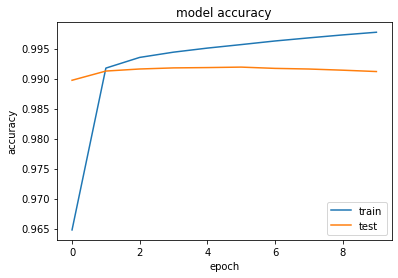

In [69]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Here there is slight increase in the accuracy of validation and training dataset

# 2. LSTM

We'll use pre-trained word embeddings in following models and allow them to be updated as well. 

**Create model architecture**

In [63]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True)) # using the LSTM Layer
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [64]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 110, 300)          17834700  
                                                                 
 lstm (LSTM)                 (None, 110, 64)           93440     
                                                                 
 time_distributed_2 (TimeDis  (None, 110, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


# Fit the model

In [65]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 21s 41ms/step - loss: 0.2795 - acc: 0.9403 - val_loss: 0.0449 - val_acc: 0.9883
Epoch 2/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0317 - acc: 0.9904 - val_loss: 0.0275 - val_acc: 0.9907
Epoch 3/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0218 - acc: 0.9925 - val_loss: 0.0241 - val_acc: 0.9915
Epoch 4/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0183 - acc: 0.9934 - val_loss: 0.0229 - val_acc: 0.9918
Epoch 5/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0164 - acc: 0.9940 - val_loss: 0.0223 - val_acc: 0.9920
Epoch 6/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0150 - acc: 0.9945 - val_loss: 0.0221 - val_acc: 0.9921
Epoch 7/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0138 - acc: 0.9949 - val_loss: 0.0221 - val_acc: 0.9922
Epoch 8/10
408/408 [==============================] - 16s 39ms

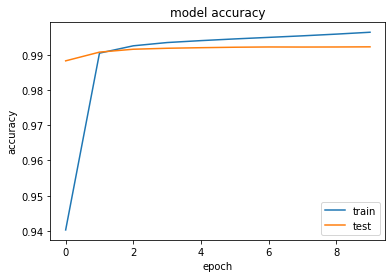

In [70]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## using LSTM there is further increase in VAL and TRAIN accuracy

# 3. GRU
### Create model architecture

In [71]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True)) ## using the GRU layer
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [72]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# check summary of model
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 110, 300)          17834700  
                                                                 
 gru (GRU)                   (None, 110, 64)           70272     
                                                                 
 time_distributed_4 (TimeDis  (None, 110, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,905,817
Trainable params: 17,905,817
Non-trainable params: 0
_________________________________________________________________


## Fit the model

In [73]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 19s 41ms/step - loss: 0.2008 - acc: 0.9629 - val_loss: 0.0320 - val_acc: 0.9898
Epoch 2/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0249 - acc: 0.9913 - val_loss: 0.0244 - val_acc: 0.9912
Epoch 3/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0189 - acc: 0.9931 - val_loss: 0.0224 - val_acc: 0.9918
Epoch 4/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0164 - acc: 0.9939 - val_loss: 0.0217 - val_acc: 0.9921
Epoch 5/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0149 - acc: 0.9944 - val_loss: 0.0214 - val_acc: 0.9922
Epoch 6/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0138 - acc: 0.9948 - val_loss: 0.0216 - val_acc: 0.9923
Epoch 7/10
408/408 [==============================] - 16s 39ms/step - loss: 0.0128 - acc: 0.9952 - val_loss: 0.0218 - val_acc: 0.9923
Epoch 8/10
408/408 [==============================] - 16s 39ms

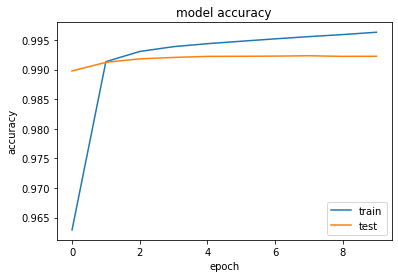

In [74]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

#### Trainable params: 17,928,985 in LSTM
#### Trainable params: 17,905,817 in GRU
**As we know GRU is more simpler model compared to lSTM, So it has less trainable parameters and faster to execute then LSTM**


# 4. Bidirectional LSTM

## Create model architecture

In [75]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True))) ## using BIDERCTIONAL LSTM 
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile the Model

In [76]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 110, 300)          17834700  
                                                                 
 bidirectional (Bidirectiona  (None, 110, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_5 (TimeDis  (None, 110, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 18,023,257
Trainable params: 18,023,257
Non-trainable params: 0
_________________________________________________________________


## Fit the Model

In [77]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 33s 68ms/step - loss: 0.2296 - acc: 0.9471 - val_loss: 0.0297 - val_acc: 0.9910
Epoch 2/10
408/408 [==============================] - 27s 66ms/step - loss: 0.0217 - acc: 0.9931 - val_loss: 0.0200 - val_acc: 0.9934
Epoch 3/10
408/408 [==============================] - 27s 66ms/step - loss: 0.0147 - acc: 0.9951 - val_loss: 0.0176 - val_acc: 0.9940
Epoch 4/10
408/408 [==============================] - 27s 66ms/step - loss: 0.0117 - acc: 0.9961 - val_loss: 0.0167 - val_acc: 0.9943
Epoch 5/10
408/408 [==============================] - 27s 66ms/step - loss: 0.0097 - acc: 0.9967 - val_loss: 0.0164 - val_acc: 0.9945
Epoch 6/10
408/408 [==============================] - 27s 66ms/step - loss: 0.0081 - acc: 0.9973 - val_loss: 0.0162 - val_acc: 0.9946
Epoch 7/10
408/408 [==============================] - 27s 66ms/step - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0168 - val_acc: 0.9946
Epoch 8/10
408/408 [==============================] - 27s 66ms

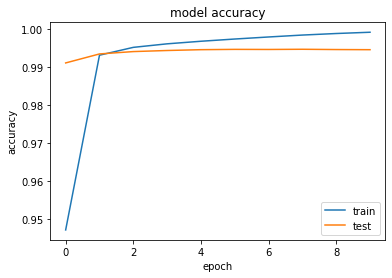

In [78]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

#### acc: 0.9991, val_acc: 0.9945.. Here we see the accuracy exponentially increased using Bidirectional

# 4. Bidirectional GRU

## Create model architecture

In [79]:
# create architecture

bidirect_gru = Sequential()
bidirect_gru.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_gru.add(Bidirectional(GRU(64, return_sequences=True))) ## Using bideirectional GRU
bidirect_gru.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile the model

In [80]:
bidirect_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
bidirect_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 110, 300)          17834700  
                                                                 
 bidirectional_1 (Bidirectio  (None, 110, 128)         140544    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 110, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 17,976,921
Trainable params: 17,976,921
Non-trainable params: 0
_________________________________________________________________


In [81]:
bidirect_training_gru = bidirect_gru.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 31s 67ms/step - loss: 0.1648 - acc: 0.9691 - val_loss: 0.0230 - val_acc: 0.9923
Epoch 2/10
408/408 [==============================] - 26s 64ms/step - loss: 0.0176 - acc: 0.9941 - val_loss: 0.0178 - val_acc: 0.9939
Epoch 3/10
408/408 [==============================] - 27s 66ms/step - loss: 0.0127 - acc: 0.9957 - val_loss: 0.0166 - val_acc: 0.9943
Epoch 4/10
408/408 [==============================] - 27s 65ms/step - loss: 0.0103 - acc: 0.9965 - val_loss: 0.0161 - val_acc: 0.9945
Epoch 5/10
408/408 [==============================] - 26s 65ms/step - loss: 0.0087 - acc: 0.9970 - val_loss: 0.0161 - val_acc: 0.9946
Epoch 6/10
408/408 [==============================] - 27s 65ms/step - loss: 0.0074 - acc: 0.9975 - val_loss: 0.0163 - val_acc: 0.9947
Epoch 7/10
408/408 [==============================] - 26s 65ms/step - loss: 0.0063 - acc: 0.9979 - val_loss: 0.0168 - val_acc: 0.9947
Epoch 8/10
408/408 [==============================] - 26s 65ms

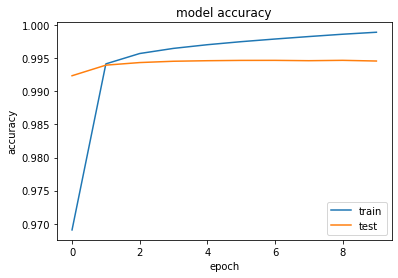

In [82]:
# visualise training history
plt.plot(bidirect_training_gru.history['acc'])
plt.plot(bidirect_training_gru.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 5. Model evaluation

**For RNN model**

In [83]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 8s 25ms/step - loss: 0.0281 - acc: 0.9914
Loss: 0.028060179203748703,
Accuracy: 0.9913816452026367


**For LSTM model**

In [84]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 4s 11ms/step - loss: 0.0233 - acc: 0.9922
Loss: 0.023281970992684364,
Accuracy: 0.9922058582305908


**For GRU model**

In [85]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 4s 11ms/step - loss: 0.0232 - acc: 0.9922
Loss: 0.023225510492920876,
Accuracy: 0.9922260046005249


**For Bidirectional LSTM**

In [86]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 7s 20ms/step - loss: 0.0193 - acc: 0.9945
Loss: 0.019281139597296715,
Accuracy: 0.9945417642593384


**For Bidirectional GRU**

In [87]:
loss, accuracy = bidirect_gru.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 7s 20ms/step - loss: 0.0192 - acc: 0.9945
Loss: 0.019223451614379883,
Accuracy: 0.9945107102394104
